In [1]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import SessionTools.two_photon as st2p

import sklearn
from sklearn.linear_model import LinearRegression as LinReg


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['pdf.use14corefonts']=True

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
date = '15_03_2023'
name = 'EPG_GCaMP_EL_jRGECO_fly2'
session = 'baseline_open_loop-003' 





In [3]:
def make_h5(h5name, metadata):
    if not os.path.exists(h5name):
        tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                                metadata['size'],metadata['layout'])
        st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{name}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

# raw data
h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{name}/{session}/data.h5'
make_h5(h5name, metadata)
f = h5py.File(h5name)
data = f['/data'][:]
    
# motion corrected
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)

In [4]:
# ROI data
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{name}/{session}/napari.pkl'
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']
    
# voltage recording data
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{name}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()
    
# align voltage recording and imaging data
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [4]:
data_corr.shape

(2, 5042, 7, 227, 263)

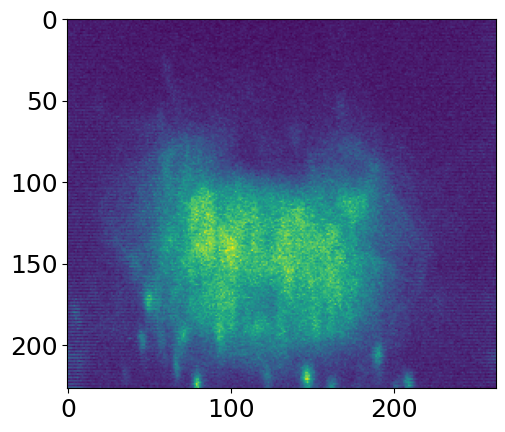

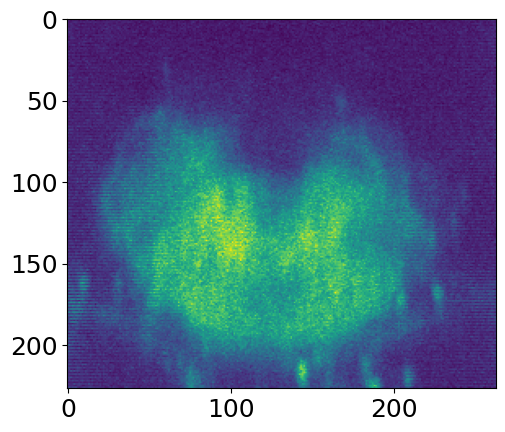

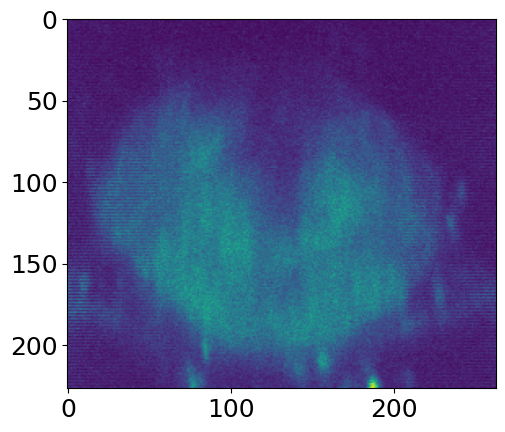

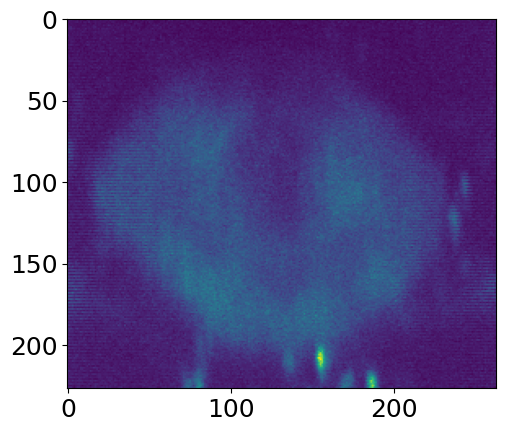

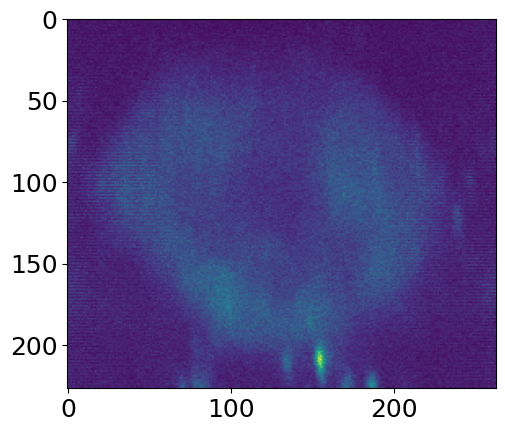

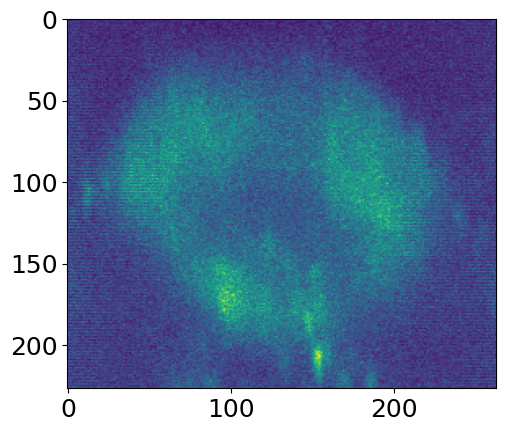

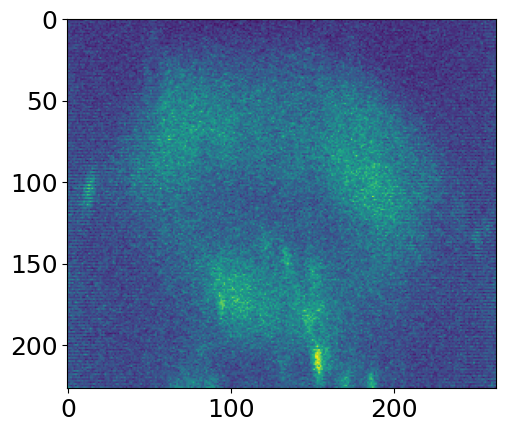

In [5]:
for slc in range(data_corr.shape[2]):
    fig, ax =plt.subplots()
    ax.imshow(data_corr[0,:,slc,:,:].mean(axis=0))

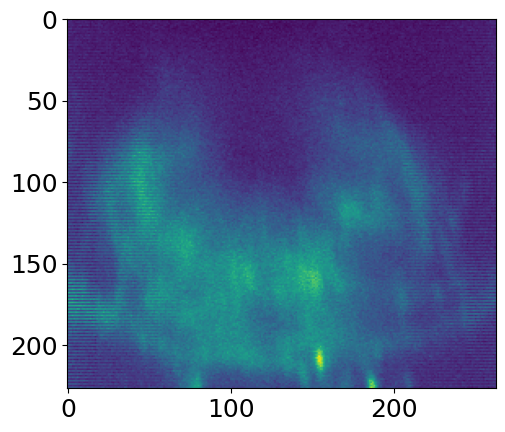

In [6]:
fig,ax = plt.subplots()
ax.imshow(data_corr[1,:,:,:,:].max(axis=1).mean(axis=0))

In [5]:
data_corr_maxp = data_corr[0,:,:,:,:].max(axis=1)
data_corr_maxp = data_corr_maxp - data_corr_maxp.mean(axis=-1,keepdims=True).mean(axis=-2,keepdims=True)
data_corr_maxp.shape



(5042, 227, 263)

In [6]:
data_corr_maxp_sm = sp.ndimage.gaussian_filter(data_corr_maxp, (3,2,2))
data_corr_maxp_z = sp.stats.zscore(data_corr_maxp_sm,axis=0)

In [7]:
np.save("/media/mplitt/SSD_storage/fig_scratch/PDLC_2023/data4vid.npy", data_corr_maxp_z[:2000,:,:])

In [8]:
df_aligned.to_pickle("/media/mplitt/SSD_storage/fig_scratch/PDLC_2023/df_4vid.npy")

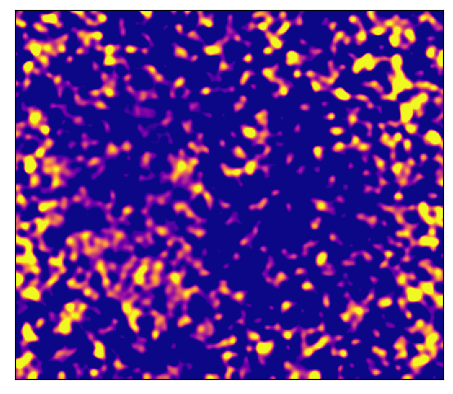

In [9]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
im = ax.imshow(data_corr_maxp_z[0,:,:], vmin=0, vmax=2.5, cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])


def animate(frame_number):
    im.set_data(data_corr_maxp_z[frame_number,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, frames=2500, interval=50, repeat=False)    

In [17]:
writervideo = animation.ImageMagickWriter(fps=10)
anim.save("/media/mplitt/SSD_storage/fig_scratch/PDLC_2023/video.html5", writer=writervideo)

ExecutableNotFoundError: [Errno 2] No such file or directory: 'convert'

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] ='C:\\ffmpeg\\bin\\ffmpeg.exe'
fig=plt.figure()
ax=fig.add_subplot(111,projection="3d")

x=np.linspace(100,150,100)
t=(x-100)/0.5
y=-.01*np.cos(t)+.5*np.sin(t)+100.01
z=.01*np.sin(t)+.5*np.cos(t)+99.5

def animate(i):
    line.set_data(x[:i],y[:i])
    line.set_3d_properties(z[:i])

ax.set_xlim3d([min(x),max(x)])
ax.set_ylim3d([min(y),max(y)])
ax.set_zlim3d([min(z),max(z)])
ax.set_title("Particle in magnetic field") 
ax.set_xlabel("X")
ax.set_xlabel("Y")
ax.set_xlabel("Z")
line,=ax.plot([],[],[])
lin_ani=animation.FuncAnimation(fig,animate)
plt.legend()

FFwriter = animation.FFMpegWriter()
lin_ani.save('animation.mp4', writer = FFwriter, fps=10)
# plt.show()